In [1]:
import sys
sys.path.append('fashion-mnist')

from utils.mnist_reader import load_mnist

X_train, y_train = load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [2]:
import numpy as np
import seaborn as sns
from random import shuffle
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm

In [3]:
val_size = int(len(X_train)*0.1)

idx = np.arange(len(X_train))
shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(54000, 784) (54000,)
(6000, 784) (6000,)
(10000, 784) (10000,)


<Axes: >

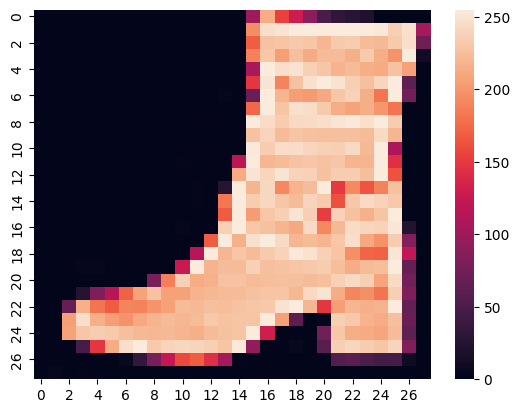

In [4]:
sns.heatmap(X_train[np.random.randint(len(X_train))].reshape(28, 28))

In [5]:
def data_loader(data: Tuple, batch_size: int, train: bool=False):
    if train:
        idx = np.arange(len(X_train))
        shuffle(idx)
        data = [x[idx] for x in data]
        
    for i in range(0, len(data[0]), batch_size):
        yield tuple(x[i:i+batch_size] for x in data)
        
def prepare_inputs(X: np.ndarray):
    return (X / 255) - 0.5

In [6]:
class Parameter:
    def __init__(self, data: np.ndarray, grad: np.ndarray=None):
        self.data = data
        self.grad = grad
        
    def __repr__(self):
        return f"Parameter(data={self.data}, grad={self.grad})"

class Module:
    def __init__(self, **parameters: Dict[str, Parameter]):
        self.parameters: Dict[str, Parameter] = parameters
    
    def __call__(self, *inputs):
        self._inputs = inputs
        self._outputs = self.forward(*inputs)
        return self._outputs

In [22]:
class Linear(Module):
    def __init__(self, input_features: int, output_features: int):
        self.w = Parameter(np.random.randn(input_features, output_features) * np.sqrt(2 / input_features))
        self.b = Parameter(np.zeros(output_features))
        super().__init__(w=self.w, b=self.b)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w.data + self.b.data
    
    def backward(self, grad_output: np.ndarray):
        X = self._inputs[0]
        self.w.grad = X.T @ grad_output
        self.b.grad = grad_output.sum(axis=0)
        return grad_output @ self.w.data.T
    
    def __repr__(self):
        return f"Linear({self.w.data.shape[0]},{self.w.data.shape[1]})"
    
class ReLU(Module):
    def forward(self, X: np.ndarray) -> np.ndarray:
        self._mask = X > 0
        return X * self._mask
    
    def backward(self, grad_output: np.ndarray):
        return grad_output * self._mask
    
    def __repr__(self):
        return f"ReLU()"
    
class ResBlock(Module):
    def __init__(self, hidden_size: int):
        self.linear = Linear(hidden_size, hidden_size)
        self.relu = ReLU()
        super().__init__(**self.linear.parameters)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        return self.relu(self.linear(X)) + X
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        return self.linear.backward(self.relu.backward(grad_output)) + grad_output
    
    def __repr__(self):
        return f"ResBlock({self.linear},{self.relu})"
    
class Model(Module):
    def __init__(self, input_features: int, num_classes: int, hidden_sizes: List[int]):
        self.layers = [Linear(input_features, hidden_sizes[0]), ReLU()] + \
            [ResBlock(h) for h in hidden_sizes] + [Linear(hidden_sizes[-1], num_classes)]

        parameters = {}
        for i, layer in enumerate(self.layers):
            parameters.update({f"layers.{i}.{k}": v for k,v in layer.parameters.items()})

        super().__init__(**parameters)
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        h = self.layers[0](X)
        for layer in self.layers[1:-1]:
            h = layer(h)

        return self.layers[-1](h)
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output)
            
        return grad_output
    
    def __repr__(self):
        layers = "\n".join([repr(layer) for layer in self.layers])
        return "Model([\n" + ",\n".join(["\t"+layer for layer in layers.split("\n")]) + "\n])"

In [23]:
def softmax(z: np.ndarray) -> np.ndarray:
    ez = np.exp(z - z.max(axis=-1, keepdims=True))
    return ez / ez.sum(axis=-1, keepdims=True)

def accuracy(preds: np.ndarray, targets: np.ndarray) -> float:
    return (preds == targets).mean().item()

In [24]:
class Loss(Module):
    def forward(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        logits -= logits.max(axis=-1, keepdims=True)
        return (np.log(np.sum(np.exp(logits), axis=-1)) - logits[np.arange(len(y)), y]).mean()
    
    def backward(self, _) -> np.ndarray:
        logits, y = self._inputs
        grads = softmax(logits)
        grads[np.arange(len(y)), y] -= 1
        return grads / len(y)

In [25]:
class SGD:
    def __init__(self, params: List[Parameter], lr: float, weight_decay: float=0.0, max_grad_norm: float=1.0):
        self.params = params
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_grad_norm = max_grad_norm
        
    def step(self):
        for param in self.params:
            param.grad *= self.max_grad_norm / max(self.max_grad_norm, (param.grad ** 2).sum())
            param.data -= self.lr * (param.grad + self.weight_decay * param.data)
            
    def zero_grad(self):
        for param in self.params:
            param.grad = None

In [32]:
input_features = 784
output_classes = 10
hidden_sizes = [32,32]
batch_size = 32
lr = 0.03
weight_decay = 0.0
num_epochs = 40

model = Model(input_features, output_classes, hidden_sizes)
loss_fn = Loss()
optim = SGD(list(model.parameters.values()), lr=lr, weight_decay=weight_decay)

In [ ]:
def train_epoch(pbar):
    pbar.total = len(X_train)
    train_loss = 0
    num_train_samples = 0
    for X, y in data_loader((X_train, y_train), batch_size, True):
        loss = loss_fn(model(prepare_inputs(X)), y)

        optim.zero_grad()
        model.backward(loss_fn.backward(None))
        optim.step()

        train_loss += (loss * len(X)).item()
        num_train_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"train_loss": train_loss / num_train_samples})
        
    return train_loss / num_train_samples
        

def evaluate(pbar, data):
    X_val, y_val = data
    pbar.total = len(X_val)
    val_loss = 0
    num_val_samples = 0
    preds = []
    for X, y in data_loader((X_val, y_val), batch_size, False):
        outputs = model(prepare_inputs(X))
        loss = loss_fn(outputs, y)
        preds += outputs.argmax(axis=-1).tolist()

        val_loss += (loss * len(X)).item()
        num_val_samples += len(X)
        pbar.update(len(X))
        pbar.set_postfix({"val_loss": val_loss / num_val_samples, "accuracy": accuracy(np.asarray(preds), y_val[:num_val_samples])})
        
    return val_loss / num_val_samples, accuracy(np.asarray(preds), y_val[:num_val_samples])

In [35]:
with tqdm() as pbar:
    pbar.set_description("Val")
    val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
    print(f"Initial: {val_loss=}, {val_accuracy}")
    
    for epoch in range(num_epochs):
        pbar.set_description("Train")
        train_loss = train_epoch(pbar)

        pbar.set_description("Val")
        val_loss, val_accuracy = evaluate(pbar, (X_val, y_val))
        
        print(f"Epoch {epoch}: {train_loss=}, {val_loss=}, {val_accuracy=}")

    pbar.set_description("Test")
    test_loss, test_accuracy = evaluate(pbar, (X_test, y_test))
    
print(f"Test accuracy: {test_loss=}, {test_accuracy}")

0it [00:00, ?it/s]

Initial: val_loss=0.3663311064347545, 0.8701666666666666
Epoch 0: train_loss=0.2853245800563215, val_loss=0.36498985993305516, val_accuracy=0.8731666666666666
Epoch 1: train_loss=0.28470911697024104, val_loss=0.36356583861857483, val_accuracy=0.872
Epoch 2: train_loss=0.2833352270736353, val_loss=0.3562744764689848, val_accuracy=0.8736666666666667
Epoch 3: train_loss=0.28390753475668234, val_loss=0.35040102503822174, val_accuracy=0.875
Epoch 4: train_loss=0.2816372452651182, val_loss=0.3788238862851262, val_accuracy=0.8688333333333333
Epoch 5: train_loss=0.27914685551554874, val_loss=0.36196162799992815, val_accuracy=0.872
Epoch 6: train_loss=0.28087511396078535, val_loss=0.36863176319677315, val_accuracy=0.8718333333333333
Epoch 7: train_loss=0.27761957819751737, val_loss=0.35810518047762313, val_accuracy=0.8748333333333334
Epoch 8: train_loss=0.27559195558923893, val_loss=0.3634747356293837, val_accuracy=0.8725
Epoch 9: train_loss=0.27494500299612484, val_loss=0.37104402306651224, va